# CTM MILP Formulation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
import time

from ctmmodels.const import *
from ctmmodels.base import BaseModel
from ctmmodels.nophasing import Constraint5Model

## Constants

In [2]:
FLOW_UNDERSAT       = 450 # veh / hr / lane
FLOW_SAT            = 600 
FLOW_OVERSAT        = 900

Timesteps : Running Time
10        : 0.32
20        : 7.18

## Using the Module

In [3]:
model = Constraint5Model(sat_flow_rate=600, demand=450)
model.generate()

In [4]:
model._constraints.keys()

['turnratios', 'greentime', 'init', 'flowcon', 'flowrate', 'greenflowrate']

In [5]:
model.solve()

Solving...
Done!
Time elapsed: 0.460045814514


0.46004581451416016

## Showing the Cell Capacities

In [6]:
df_x, df_y, df_g = model.return_solution()

In [7]:
df_x_source = df_x[df_x.cell == (CELL_SOURCE,0,1)].sort_values(by='timestep')
df_x_normal0 = df_x[df_x.cell == (CELL_NORMAL,0,1)].sort_values(by='timestep')
df_x_normal1 = df_x[df_x.cell == (CELL_NORMAL,1,1)].sort_values(by='timestep')
df_x_normal2 = df_x[df_x.cell == (CELL_NORMAL,2,1)].sort_values(by='timestep')
df_x_left = df_x[df_x.cell == (CELL_MOVEMENT,LEFT_TURN,1)].sort_values(by='timestep')
df_x_through = df_x[df_x.cell == (CELL_MOVEMENT,THROUGH_TURN,1)].sort_values(by='timestep')
df_x_right = df_x[df_x.cell == (CELL_MOVEMENT,RIGHT_TURN,1)].sort_values(by='timestep')
df_x_sink = df_x[df_x.cell == model.S[(CELL_MOVEMENT,THROUGH_TURN,1)][0]].sort_values(by='timestep')

df_x_approach = df_x_source.append(df_x_normal1).append(df_x_normal2).append(df_x_normal0).append(df_x_through).append(df_x_sink)
df_x_movement = df_x_left.append(df_x_through).append(df_x_right)
df_x_approach = df_x_approach.pivot(index='timestep', columns='cell', values='volume')
df_x_movement = df_x_movement.pivot(index='timestep', columns='cell', values='volume')

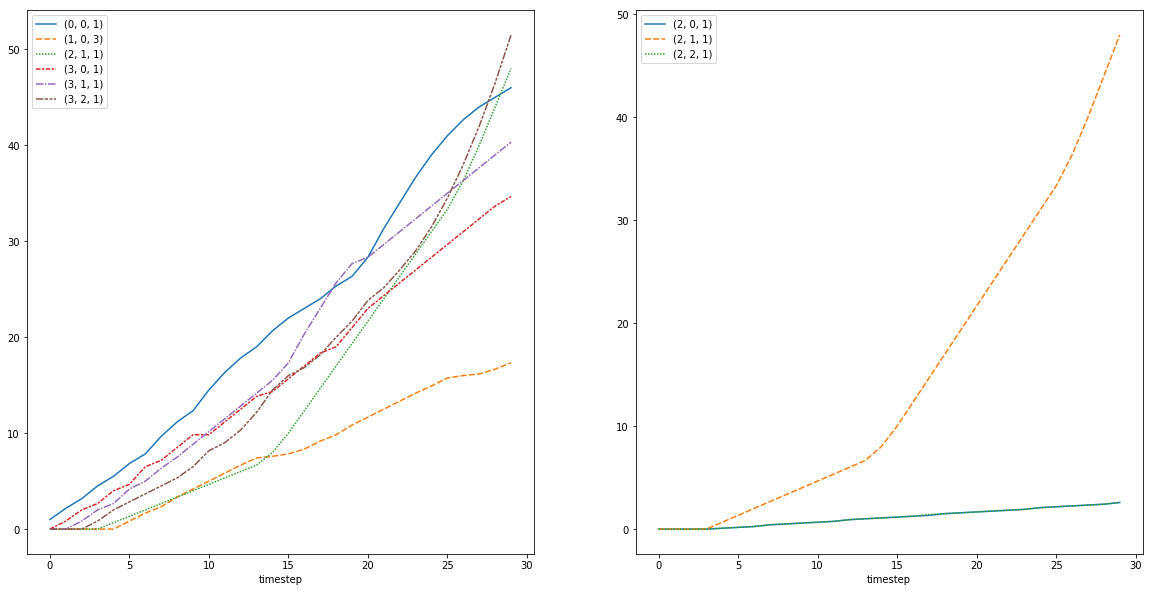

In [8]:
_, axs = plt.subplots(1,2,figsize=(20,10))
sns.lineplot(data=df_x_approach.cumsum(), ax=axs[0])
sns.lineplot(data=df_x_movement.cumsum(), ax=axs[1])

This linear, cascading cumulative sum of consecutive cells (except for the through cell) means that the turning ratio is working fine.

In [9]:
df_y_normal0 = df_y[df_y.cell_from == (CELL_SOURCE,0,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_normal1 = df_y[df_y.cell_from == (CELL_NORMAL,0,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
df_y_normal2 = df_y[df_y.cell_from == (CELL_NORMAL,1,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')

df_y_ltr = df_y[df_y.cell_from == (CELL_NORMAL,2,1)].groupby(['cell_to', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep').reset_index()

df_y_through = df_y_ltr[df_y_ltr.cell_to == (CELL_MOVEMENT,THROUGH_TURN,1)]
df_y_through['cell_from'] = [(CELL_NORMAL,2,1)] * df_y_through.shape[0]
df_y_through = df_y_through[['cell_from', 'timestep', 'flow']].set_index(['cell_from', 'timestep'])

df_y_sink = df_y[df_y.cell_from == (CELL_MOVEMENT,THROUGH_TURN,1)].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')

df_y_approach = df_y_normal0.append(df_y_normal1).append(df_y_normal2).append(df_y_through).append(df_y_sink)
df_y_approach.reset_index(inplace=True)
df_y_approach = df_y_approach.pivot(index='timestep', columns='cell_from', values='flow')

df_y_movement = df_y_ltr.pivot(index='timestep', columns='cell_to', values='flow')

/home/franciszacdlc/.virtualenvs/localsim2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


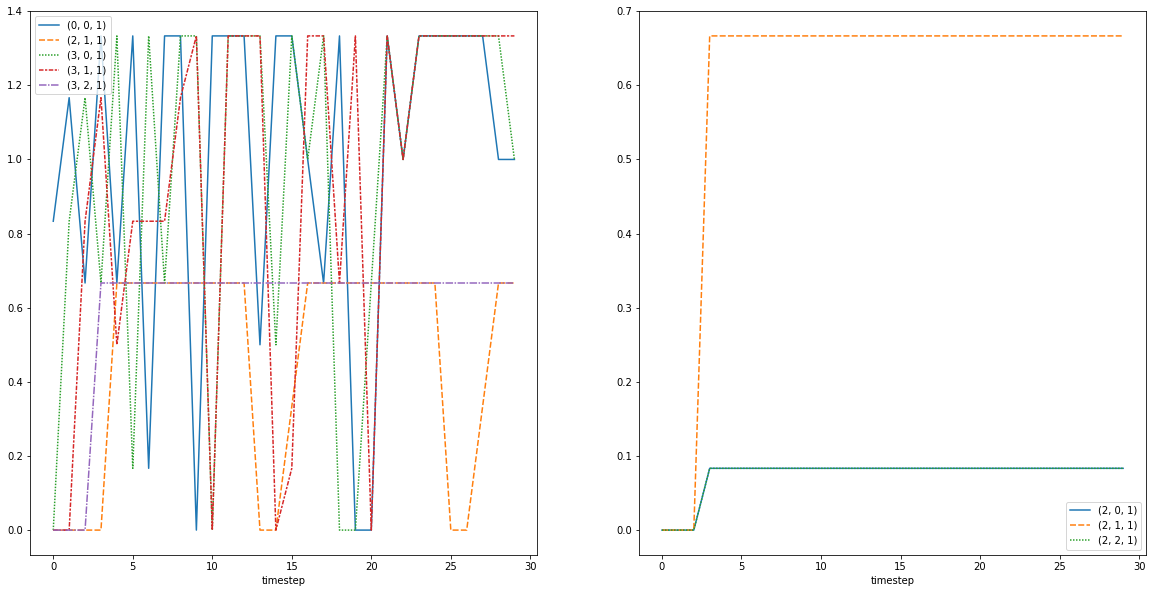

In [10]:
_, axs = plt.subplots(1,2,figsize=(20,10))
sns.lineplot(data=df_y_approach, ax=axs[0])
sns.lineplot(data=df_y_movement, ax=axs[1])

### Comparing the Green Signal and the Flow

In [11]:
df_g_specific = df_g[df_g.cell == (CELL_MOVEMENT,THROUGH_TURN,1)].sort_values(by='timestep')
df_y_specific = df_y[(df_y.cell_from == (CELL_MOVEMENT,THROUGH_TURN,1)) & (df_y.cell_to == model.S[(CELL_MOVEMENT,THROUGH_TURN,1)][0])].sort_values(by='timestep')
df_y_specific = df_y_specific.groupby(['timestep', 'cell_from']).agg({'flow': 'sum'}).reset_index()

df_g_y = pd.merge(df_g_specific, df_y_specific, left_on=['timestep', 'cell'], right_on=['timestep', 'cell_from'])[
    ['timestep', 'is_green', 'flow']
]

df_g_y.set_index('timestep', inplace=True)

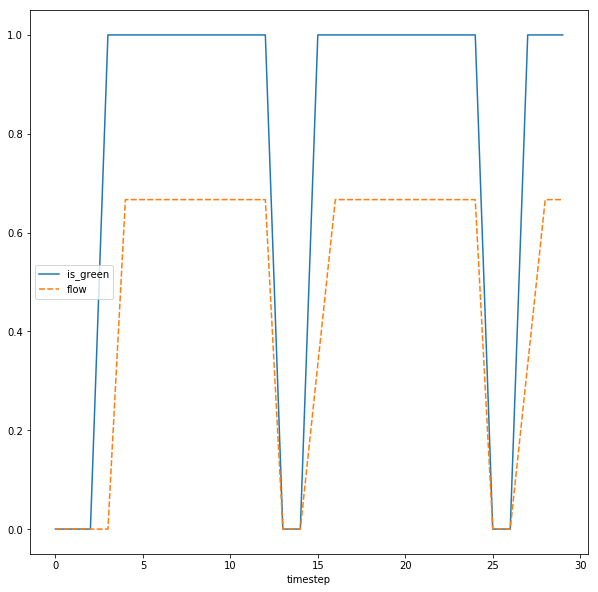

In [12]:
_, ax = plt.subplots(figsize=(10,10))
sns.lineplot(data=df_g_y)